In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, norm

Загрузим датасет с kaggle для проведения AB теста. Тестируется фича на сайте. <br>
Пользователи поделены на две группы:
1. control (контроль или A группа). Для пользователей этой группы новая фича не вводилась
2. variant (тест или B группа). На этих пользователях тестировалась новая фича. <br>

Есть столбцы USER_ID - id пользователя, VARIANT_NAME - группа, в которую попал пользователь, REVENUE - сумма, которую пользователь потратил на покупку на сайте

In [229]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)
df.head()
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [230]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [231]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

Число уникальных пользователей 6324 не совпадает с общим числом записей в таблице 10000. Значит какие-то пользователи совершали несколько покупок 

Попробуем посмотреть на разбивку по группам

In [172]:
group_sizes = df.groupby('VARIANT_NAME').count()
group_sizes

,USER_ID,REVENUE
VARIANT_NAME,,
control,4984,4984
variant,5016,5016


Пользователи разбиты по группам примерно поровну

Проверим есть ли пользователи, находящиеся в обеих группах

In [232]:
duplicates = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
duplicates

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [175]:
duplicates/duplicates.sum()

VARIANT_NAME
1    0.756325
2    0.243675
Name: count, dtype: float64

Имеется значительное количество пользователей (около 24%), находящихся в обеих группах. Их надо исключить для проведения AB теста

In [176]:
single_group = (df.groupby('USER_ID')['VARIANT_NAME'].nunique()==1)
single_group = single_group[single_group]
single_group

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool

In [177]:
df = df[df['USER_ID'].isin(single_group.index)]
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0]==duplicates.iloc[0]

True

Построим гистограмму распределения выручки по пользователям

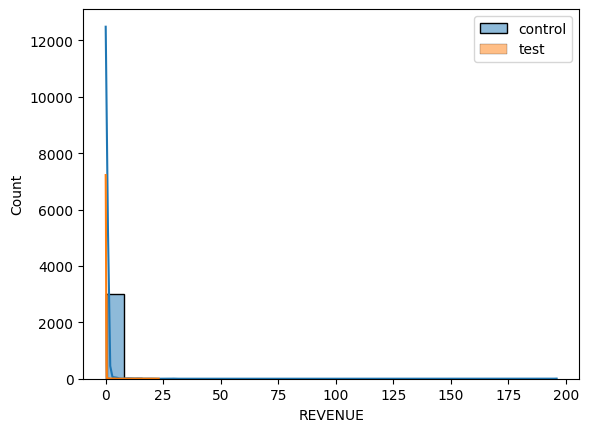

In [178]:
df_control = df[df['VARIANT_NAME']=='control']['REVENUE']
df_test = df[df['VARIANT_NAME']=='variant']['REVENUE']
sns.histplot(df_control, kde=True, bins=25, label='control')
sns.histplot(df_test, kde=True, bins=25, label='test')
plt.legend()

В районе 200 виден выброс

In [179]:
df.sort_values(by='REVENUE', ascending=False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3366,1189,control,0.00
3363,2051,variant,0.00
3362,3276,variant,0.00
3360,1608,variant,0.00


Уберем пользователя с USER_ID 3342

In [180]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [181]:
df = df[df['USER_ID'] != 3342]
print(df[df['REVENUE']==0].count())
print()
print(df[df['REVENUE']!=0].count())

USER_ID         5973
VARIANT_NAME    5973
REVENUE         5973
dtype: int64

USER_ID         96
VARIANT_NAME    96
REVENUE         96
dtype: int64


Посмотрим есть ли пользователи, у которых есть посещение сайта как без покупок (REVENUE=0), так и с покупками (REVENUE != 0)

In [182]:
df.loc[(df['REVENUE']==0) & (df['USER_ID'].isin(df.loc[df['REVENUE']!=0, 'USER_ID'].values)), 'USER_ID'].count()

52

Предположим, что число упоминаний одного и того же пользователя это количество просмотров на сайте, а REVENUE имеет ненулевое значение, если пользователь что-то купил.

In [183]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()
df


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


Посчитаем некоторые полезные для анализа метрики <br>
Сначала рассмотрим всех пользователей

In [184]:
metrics = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique', 'REVENUE': ['sum', 'mean', 'median', 'count']})
orders_per_user = metrics.loc[:, ('REVENUE', 'count')] / metrics.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = metrics.loc[:, ('REVENUE', 'sum')] / metrics.loc[:, ('USER_ID', 'nunique')]
metrics.loc[:, ('per_user', 'orders')] = orders_per_user
metrics.loc[:, ('per_user', 'revenue')] = revenue_per_user
metrics

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

Выручка на одного пользователя для тестовой группы меньше, чем для контроля

Теперь рассмотрим только пользователей, которые совершали покупки, то есть REVENUE не рано нулю

In [185]:
metrics_paid = df.loc[df['REVENUE']!=0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique', 'REVENUE': ['sum', 'mean', 'median', 'count']})
orders_per_user_paid = metrics_paid.loc[:, ('REVENUE', 'count')] / metrics_paid.loc[:, ('USER_ID', 'nunique')]
revenue_per_user_paid = metrics_paid.loc[:, ('REVENUE', 'sum')] / metrics_paid.loc[:, ('USER_ID', 'nunique')]
metrics_paid.loc[:, ('per_user', 'orders')] = orders_per_user_paid
metrics_paid.loc[:, ('per_user', 'revenue')] = revenue_per_user_paid
metrics_paid

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Построим распределение выручки по всем пользователям

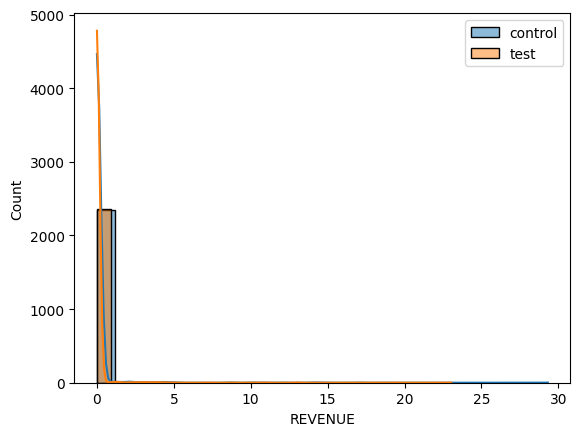

In [187]:
df_control = df[df['VARIANT_NAME']=='control']['REVENUE']
df_test = df[df['VARIANT_NAME']=='variant']['REVENUE']
sns.histplot(df_control, kde=True, bins=25, label='control')
sns.histplot(df_test, kde=True, bins=25, label='test')
plt.legend()

Большинство пользователей имеют REVENUE=0. Построим распределение для тех, у кого REVENUE не равно нулю

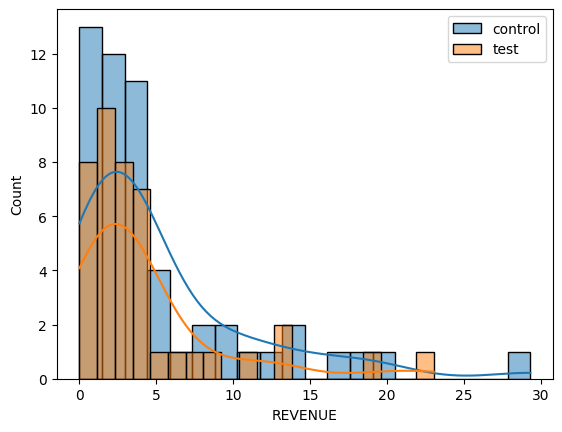

In [188]:
df_control_nonzero = df[(df['VARIANT_NAME']=='control') & (df['REVENUE']!=0)]['REVENUE']
df_test_nonzero = df[(df['VARIANT_NAME']=='variant') & (df['REVENUE']!=0)]['REVENUE']
sns.histplot(df_control_nonzero, bins=20, kde=True, label='control')
sns.histplot(df_test_nonzero, bins=20, kde=True, label='test')
plt.legend()

Видно, что REVENUE распределена не нормально. Чтобы в этом убедиться, рассмотрим критерий Шапиро-Уилка. Рассмотрим следующие нулевую и альтернативную гипотезы:<br>
$H_0$: Выборка из нормального распределения <br>
$H_1$: Выборка не из нормального распределения

In [190]:
shapiro(df.loc[df.VARIANT_NAME=='variant', 'REVENUE'])

ShapiroResult(statistic=0.06145986897942335, pvalue=9.962810723092505e-76)

На уровне значимости $\alpha$=0.05 отвергаем нулевую гипотезу. Таким образом, величины распределены не нормально

Рассмотрим критерий Манна-Уитни

In [193]:
MW_test = mannwhitneyu(df_test, df_control)
print('statistic', MW_test[0])
print('pvalue', MW_test[1])

statistic 2845109.0
pvalue 0.24799555106821947


In [194]:
MW_test_nonzero = mannwhitneyu(df_test_nonzero, df_control_nonzero)
print('statistic', MW_test_nonzero[0])
print('pvalue', MW_test_nonzero[1])

statistic 1029.0
pvalue 0.5314192217084708


Выборки распределены не нормально. Тем не менее центральная предельная теорема дает основания воспользоваться t-тестом

Обозначим тестовую выборку и контроль за $T$ и $C$ соответственно. Рассмотрим следующие гипотезы:<br>
$H_0$: $\mathop{{}\mathbb{E}}T$ = $\mathop{{}\mathbb{E}}C$ <br>
$H_1$: $\mathop{{}\mathbb{E}}T$ > $\mathop{{}\mathbb{E}}C$

In [210]:
t_test = ttest_ind(df_test, df_control)
print('statistic', t_test[0])
print('pvalue', t_test[1])

statistic -1.353347564404142
pvalue 0.1760086156257086


In [197]:
t_test_nonzero = ttest_ind(df_test_nonzero, df_control_nonzero)
print('statistic', t_test_nonzero[0])
print('pvalue', t_test_nonzero[1])

statistic -0.7968567151823726
pvalue 0.42756390222211027


На уровне значимости $\alpha$=0.05 не можем отвергнуть нулевую гипотезу, так как $pvalue>\alpha$ 

Построим распределение среднего значения выручки, используя bootstrap

In [201]:
def boostrap(control, test):
    batch_size = 100
    stats_sample = []
    boot_samples_size = len(control)
    for i in range(0, boot_samples_size, batch_size):
        control_sample = np.random.choice(control, size=(len(control), batch_size), replace=True)
        test_sample = np.random.choice(test, size=(len(test), batch_size), replace=True)
        C = np.mean(control_sample, axis=0)
        T = np.mean(test_sample, axis=0)
        stats_sample += list([C, T])
    return stats_sample


Распределение среднего REVENUE для всех пользователей

<Axes: ylabel='Density'>

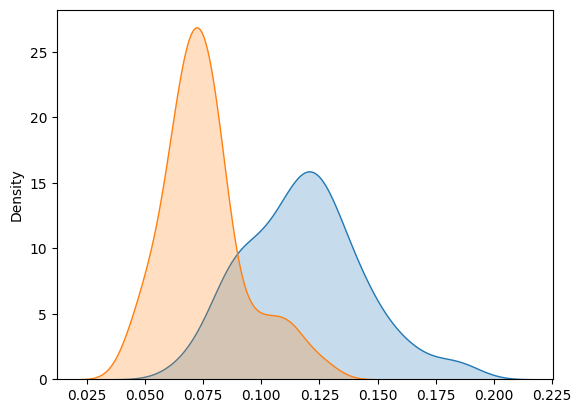

In [ ]:
control = np.array(df_control)
test = np.array(df_test)
stats_sample = boostrap(control, test)
sns.kdeplot(stats_sample[0], fill=True, label='control')
sns.kdeplot(stats_sample[1], fill=True, label='test')

Распределение среднего REVENUE только для пользователей, которые совершили покупку

<Axes: ylabel='Density'>

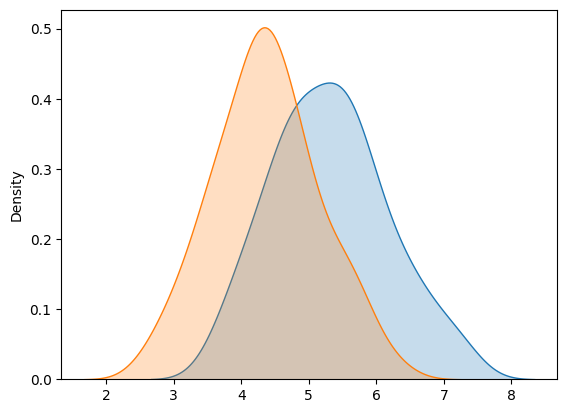

In [208]:
control_nonzero = np.array(df_control_nonzero)
test_nonzero = np.array(df_test_nonzero)
stats_sample_nonzero = boostrap(control_nonzero, test_nonzero)
sns.kdeplot(stats_sample_nonzero[0], fill=True, label='control')
sns.kdeplot(stats_sample_nonzero[1], fill=True, label='test')

Видно, что распределения сильно перекрываются, что интуитивно также говорит о неправильности нашей альтернативной гипотезы

В заключение, напишем свою функцию для t-теста и сравним с реализацией в scipy. Свой код может быть полезен для использования в других проектах, так как он обеспечивает большую гибкость

In [222]:
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    variance_control  = np.var(control) / len(control)

    mean_test = np.mean(test)
    variance_test = np.var(test)/len(test)

    difference_mean = mean_test - mean_control
    difference_mean_var  = variance_test + variance_control
    
    difference_distribution = norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([0.025, 0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return pvalue, effect, ci_length, left_bound, right_bound

In [227]:
pvalue, effect, ci_length, left_bound, right_bound = absolute_ttest(control, test)
print('ttest pvalue', pvalue)
print('confidence interval', ci_length, left_bound, right_bound)

ttest pvalue 0.17596068469551795
confidence interval 0.11582634040908572 -0.09790050419826007 0.01792583621082565


Видно совпадение значения pvalue с реализацией в scipy

Реализуем также относительный t-тест

In [ ]:
def relative_ttest(control, test):
    mean_control = np.mean(control)
    variance_control  = np.var(control) / len(control)

    mean_test = np.mean(test)
    variance_test = np.var(test)/len(test)

    difference_mean = mean_test - mean_control
    difference_mean_var  = variance_test + variance_control
    
    covariance = -variance_control

    relative_mu = difference_mean / mean_control
    relative_var = difference_mean_var / (mean_control ** 2) \
                    + variance_control * ((difference_mean ** 2) / (mean_control ** 4))\
                    - 2 * (difference_mean / (mean_control ** 3)) * covariance
    relative_distribution = norm(loc=relative_mu, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    effect = relative_mu
    return pvalue, effect, ci_length, left_bound, right_bound

In [228]:
pvalue, effect, ci_length, left_bound, right_bound = relative_ttest(control, test)
print('ttest pvalue', pvalue)
print('confidence interval', ci_length, left_bound, right_bound)

ttest pvalue 0.08762090171344905
confidence interval 0.7985207608410168 -0.7472106295954871 0.05131013124552963


Таким образом, был проведен анализ датасета и проведен A/B тест


Рассматривались две группы пользователей, для группы A фича не вводилась, для группы B вводилась. Гипотеза была в том, что выручка в группе B увеличилась.

Результаты оказались статистически не значимы. Ожидаемого прироста выручки от введения фичи не оказалось